# Import Cruft

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

import jax
import jax.numpy as jnp
from jax import random
import blackjax


# Performing calculations on all extraction steps

The Swindle and Olson dataset did not include duration of extraction steps.  We impute the durations by fitting to Figure 1 of Shuster and Weiss.  However, this figure only goes up to 750C, so some extraction steps do not have imputed durations.

Some calculations must be performed relative to all of the data (e.g. fractional release denominator).  Other calculations must be performed without the high-temperature extraction data to avoid NaNs polluting our Bayesian code.  We begin with calculations on the entire dataset.

In [2]:
entire_df = pd.read_csv('data/nakhla1_parsed_fitted.csv')[["Temp", "39Ar", "std_39Ar", "seconds_per_extraction_step"]]
total_39Ar = entire_df['39Ar'].sum()
entire_df['ΔF'] = entire_df['39Ar'] / total_39Ar          # fractional release per extraction step
entire_df['F'] = entire_df['ΔF'].cumsum()                 # cumulative release
entire_df['R'] = 1 - entire_df['F'].shift(fill_value=0)   # % of 39Ar left
entire_df['T_K'] = entire_df['Temp'] + 273.15

# Fechtig & Kalbitzer (1966) piece‑wise solution for a sphere
def y_from_F(F):
    if F < 0 or F > 1:
        return np.nan
    if F < 0.85:                     # low‑loss branch: F = (6/√π)√y – 3y
        a = 6/np.sqrt(np.pi)
        disc = a*a - 12*F
        s = (a - np.sqrt(disc)) / 6          # choose the small root
        y = s**2
    else:                           # high‑loss branch: F = 1 – 6/π² e^(‑π²y)
        y = -(1/np.pi**2) * np.log((1 - F)*np.pi**2 / 6)
        # the last extraction step is invalid and accounts for >15% of the 39Ar
        # so we should never use this branch of the approximation
        raise ValueError("should never be used")
    return y

entire_df['y'] = entire_df['F'].apply(y_from_F)  # get dimensionless time aka "diffusion progress"


In [3]:
entire_df.head()

,Temp,39Ar,std_39Ar,seconds_per_extraction_step,ΔF,F,R,T_K,y
0,250,0.8243,0.08243,23.023992,0.003378,0.003378,1.000000,523.15,9.972739e-07
1,275,0.9584,0.09584,117.189533,0.003927,0.007305,0.996622,548.15,4.674091e-06
2,300,1.2445,0.12445,274.907229,0.005099,0.012404,0.992695,573.15,1.351423e-05
3,325,2.2650,0.22650,1507.021186,0.009281,0.021685,0.987596,598.15,4.150695e-05
4,350,4.8860,0.48860,2167.500405,0.020020,0.041705,0.978315,623.15,1.551885e-04


# Creating filtered dataset

The dataset columns will define a log-likelihood, so we now create a filtered df to only extraction steps with imputed durations (those performed at <750C).

In [4]:
filtered_df = entire_df.dropna()

We can now plot the reproduction of Figure 1.

/var/folders/j_/gtf27dt106j4lt576pm77g_40000gn/T/ipykernel_34478/1677384801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['lnD/rho^2'] = np.log(entire_df['y'].diff().shift(-1) / entire_df['seconds_per_extraction_step'])  # from y=D/\rho^22 * Δt
/var/folders/j_/gtf27dt106j4lt576pm77g_40000gn/T/ipykernel_34478/1677384801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['10K*invT'] = 10**4 / filtered_df['T_K']


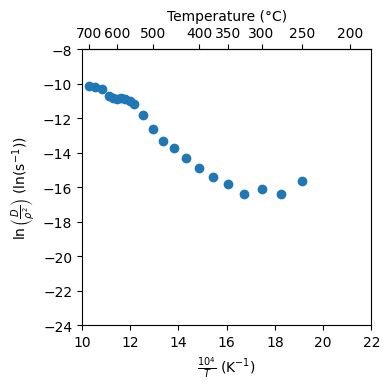

In [5]:
filtered_df['lnD/rho^2'] = np.log(entire_df['y'].diff().shift(-1) / entire_df['seconds_per_extraction_step'])  # from y=D/\rho^22 * Δt
filtered_df['10K*invT'] = 10**4 / filtered_df['T_K']
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(filtered_df['10K*invT'], filtered_df['lnD/rho^2'])
plt.xlabel(r'$\frac{10^4}{T}$ (K$^{-1}$)')
plt.ylabel(r'$\ln\left(\frac{D}{\rho^2}\right)$ (ln(s$^{-1}$))')
ax2 = plt.gca().secondary_xaxis('top', functions=(lambda x: 1e4/x - 273.15, lambda x: 1e4/(x + 273.15)))
ax2.set_xlabel('Temperature (°C)')
ax2.set_xticks([700, 600, 500, 400, 350, 300, 250, 200])
ax.set_ylim(-24, -8)
ax.set_xlim(10, 22)
plt.tight_layout()
plt.show()

And we can now set up the tensors that will be used to fit the multiple domain model.

In [6]:
temps_K = filtered_df["T_K"].values
f_obs = filtered_df["ΔF"].values
sigma_obs = filtered_df["std_39Ar"].values / total_39Ar + 1e-12
dt = filtered_df["seconds_per_extraction_step"].values

# Fitting the Multiple Domain Model

We define our priors and hyperparameters first.

In [7]:
# Number of domains
num_domains = 2

# priors
# Ea prior : N(117, 5)
# logD0_r2 prior : N(5.7, 0.5)
# means are HRD values from Shuster + Weiss
# stds are half the reported one-sided margin of error.
Ea_prior_mode = 117.0
Ea_prior_sigma = 0.5
Ea_prior_mu = jnp.log(Ea_prior_mode) + Ea_prior_sigma**2
logD0_r2_prior_mean = 5.7
logD0_r2_prior_std = 2.0
dirichlet_alphas = jnp.array([1.0] * num_domains)
diffusion_repulsion = 1e2

# MCMC Hyperparameters
num_warmup = 1000
num_steps = 100
num_chains = 1000
key = random.PRNGKey(0)
chain_keys = random.split(key, num_chains)
nuts_hyperparams = {"max_num_doublings": 10}

run_name = f"{num_domains}domains_{num_chains}chains_{num_steps}steps"

Now we define our log-likelihood function.  `fractional_release` inverts `y_from_F` in a JAX-friendly way.  Although unlikely to ever occur, we impose a penalty on negative activation energies to only get physically realizable fits.

In [8]:
def stick_breaking(phi_raw):
    """Convert (k-1,) unconstrained to k-simplex via stick-breaking."""
    phi_raw = jnp.asarray(phi_raw)
    probs = jax.nn.sigmoid(phi_raw)  # (k-1,)
    
    # Compute cumprod of (1-probs) with a 1.0 prepended
    one_minus_probs = 1.0 - probs
    remaining = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(one_minus_probs)])
    
    # Final proportions: probs * remaining, plus final remainder
    phi_pieces = probs * remaining[:-1]
    phi = jnp.concatenate([phi_pieces, remaining[-1:]])
    # jax.debug.print("phi: {:.2f}, phi_raw: {:.2f}", phi[0], phi_raw[0])
    return phi


def fractional_release(y):
    """
    Fechtig & Kalbitzer (1966) piece-wise approximation for a sphere.

      y ≡ ∫ D(t) dt / r²

    Valid for 0 ≤ y ≲ 10 (covers the entire laboratory step-heating range).
    """
    y = jnp.asarray(y)
    F_short = 6 * jnp.sqrt(y / jnp.pi) - 3 * y
    F_long  = 1 - (6 / jnp.pi**2) * jnp.exp(-jnp.pi**2 * y)
    F = jnp.where(y < 0.3, F_short, F_long)
    return jnp.clip(F, 0.0, 1.0)        # numerical safety


def log_prob(params):
    Ea, logD0_r2, phi_raw = params["Ea"], params["logD0_r2"], params["phi_raw"]
    # logD0_r2, phi_raw = params["logD0_r2"], params["phi_raw"]
    phi  = stick_breaking(phi_raw)
    D_r2 = jnp.exp(logD0_r2)[:, None]            # (k,1)

    R, T = 8.314, temps_K[None, :]               # J mol⁻¹ K⁻¹
    y_inc = D_r2 * jnp.exp(-Ea[:, None]*1e3 / (R*T)) * dt   # (k,m)
    # y_inc = D_r2 * jnp.exp(-117.0 * 1e3 / (R*T)) * dt   # (k,m)
    y_cum = jnp.cumsum(y_inc, axis=1)
    Fcum  = fractional_release(y_cum)            # (k,m)
    dF    = jnp.diff(Fcum, axis=1,
                     prepend=jnp.zeros((num_domains,1)))   # (k,m)

    # --- mix domains ---
    dF_mix      = (phi @ dF)                     # (m,)
    F_final_mix = (phi @ Fcum[..., -1])          # scalar < 1
    f_pred      = dF_mix / F_final_mix           # normalised spectrum

    ll = jnp.sum(
        -0.5 * ((f_obs - f_pred)/sigma_obs)**2
        - jnp.log(sigma_obs)
        - 0.5 * jnp.log(2*jnp.pi)
    )
    # prior = jnp.sum(
    #     -jnp.log(Ea) - 0.5 * (jnp.log(Ea) - Ea_prior_mu)**2 / Ea_prior_sigma**2
    #     -0.5 * (logD0_r2 - logD0_r2_prior_mean)**2 / logD0_r2_prior_std**2
    #     + (dirichlet_alphas - 1) * jnp.log(phi)
    # )
    # calculate pairwise diffusion distances
    # pairwise_diff = logD0_r2[:, None] - logD0_r2[None, :]       # (k, k)
    # kernel        = diffusion_repulsion * jnp.exp(-0.5 * pairwise_diff ** 2)
    # repulsion     = -jnp.sum(kernel * (1.0 - jnp.eye(num_domains)))
    
    penalty_for_negative_ea = jnp.sum(jnp.where(Ea < 0, -1e6, 0))
    # jax.debug.print("ll: {:.2f}, penalty: {:.2f}, prior: {:.2f}, repulsion: {:.2f}", 
                #    ll, penalty_for_negative_ea, prior, repulsion)
    return ll + penalty_for_negative_ea

# Warming up with Blackjax

This window adaptation should mimic Stan's HMC implementation.  `step_sizes` should be nonzero.  This takes about ~2 minutes to run on an M3 Macbook.

In [9]:
def init_params(key):
    """Updated init_params function with (k-1) phi_raw dimensions."""
    
    # draw the three domain-level vectors
    subk_Ea, subk_logD0r2, subk_phi = random.split(key, 3)

    # Ea        = jnp.exp(random.normal(subk_Ea, (num_domains,)) * Ea_prior_sigma + Ea_prior_mu)
    Ea = jnp.array([117.0] * num_domains)
    logD0_r2  = random.normal(subk_logD0r2, (num_domains,)) * logD0_r2_prior_std + logD0_r2_prior_mean
    phi_raw   = jnp.zeros((num_domains-1,))

    return {"Ea": Ea, "logD0_r2": logD0_r2, "phi_raw": phi_raw}
    # return {"logD0_r2": logD0_r2, "phi_raw": phi_raw}



init_params_batch = jax.vmap(init_params)(chain_keys)

# -------------------------------------------------
# warm-up for each chain: return arrays only
# -------------------------------------------------
def warmup_one_chain(key, init_p):
    warm  = blackjax.window_adaptation(blackjax.nuts, log_prob, initial_step_size=1e-3, is_mass_matrix_diagonal=False, target_acceptance_rate=0.95, **nuts_hyperparams)
    (state, tuned), _ = warm.run(key, init_p, num_steps=num_warmup)
    return state, tuned["step_size"], tuned["inverse_mass_matrix"]

# vmap it across many chains
states, step_sizes, inv_mats = jax.vmap(warmup_one_chain)(chain_keys,
                                                          init_params_batch)
step_sizes

Array([3.64403008e-03, 7.25101108e-06, 2.83584837e-03, 1.36342162e-04,
       4.42197721e-04, 9.76016381e-05, 6.76277632e-05, 5.52916375e-04,
       7.32159970e-05, 6.35590113e-04, 5.53863235e-02, 5.79806045e-03,
       1.07085973e-03, 3.97225631e-06, 1.77772323e-04, 7.20376964e-04,
       5.96369659e-07, 1.03562925e-04, 9.05613924e-05, 8.97503924e-06,
       6.36739205e-05, 1.62205519e-03, 1.21529192e-04, 1.41948345e-04,
       2.28399608e-06, 9.80896642e-04, 2.32773623e-03, 2.38094595e-03,
       1.87588332e-04, 1.94187069e-05, 4.17017436e-05, 8.31465295e-05,
       1.56723824e-03, 2.11074930e-05, 6.18598351e-05, 7.05935454e-05,
       1.34715182e-03, 1.02686117e-05, 1.84720731e-04, 1.28842330e-05,
       1.80315517e-03, 5.39655797e-04, 8.08181212e-05, 2.41070538e-05,
       4.11259498e-05, 4.22929588e-04, 2.27365596e-03, 3.22645414e-04,
       1.50068590e-05, 2.45507894e-04, 8.57056657e-05, 5.48659318e-06,
       2.53881095e-04, 2.94618163e-04, 4.13926100e-05, 4.48265229e-04,
      

In [10]:
min(step_sizes), max(step_sizes)

(Array(5.9636966e-07, dtype=float32, weak_type=True),
 Array(0.1822285, dtype=float32, weak_type=True))

# Running MCMC

Now we get the samples.  This takes several minutes running on an M3 Macbook.

In [11]:
# shapes:
#   states.position["Ea"]        ->  (chains, k)
#   step_sizes                   ->  (chains,)
#   inv_mats["Ea"]               ->  (chains, k)   (diagonal form)

def run_chain(state, keys, step_size, inv_mass):
    """Return (final_state, positions_over_time)."""
    # build kernel *once* for this chain
    kernel = blackjax.nuts(log_prob, step_size, inv_mass, **nuts_hyperparams)

    def one_step(carry, key):
        st = carry
        st, _ = kernel.step(key, st)
        return st, st.position          # collect sample

    final_state, positions = jax.lax.scan(one_step,  state, keys)
    return final_state, positions       # positions: pytree (time,k)

# vmapped over the chain axis
run_all_chains = jax.vmap(run_chain,
                          in_axes=(0, 0, 0, 0))   # chain-wise

# ------------------------------------------------------------
# 2.  Execute – single JIT compile
# -----------------------------------------------------------

# Make per-chain key-stacks:  (chains, num_samples, 2)
sample_keys = jax.vmap(
    lambda k: random.split(k, num_steps)
)(chain_keys)

final_states, trace_positions = run_all_chains(
    states,               # (chains, …)
    sample_keys,          # (chains, num_samples, 2)
    step_sizes,           # (chains,)
    inv_mats,             # pytree (chains, …)
)

# trace_positions is a pytree whose leaves are (chains, time, k)
# swap axes so time is first:  (time, chains, k)
trace_positions = jax.tree.map(lambda x: jnp.swapaxes(x, 0, 1),
                               trace_positions)

# ------------------------------------------------------------
# 3.  Prepend warm-up end-positions
# ------------------------------------------------------------
warmup_pos = states.position                  # pytree (chains,k)

full_samples = {
    p: jnp.concatenate([
            warmup_pos[p][None, ...],         # shape (1, chains, k)
            trace_positions[p]                # shape (time, chains, k)
        ],
        axis=0                               # time axis
    )
    for p in warmup_pos.keys()               # 'Ea', 'logD0_r2', 'phi_raw'
}
full_samples

{'Ea': Array([[[116.741425, 362.12775 ],
         [105.798485, 138.40898 ],
         [146.05077 , 125.95758 ],
         ...,
         [135.63228 , 111.24872 ],
         [107.62701 , 137.75098 ],
         [118.85816 , 116.33276 ]],
 
        [[113.51927 , 327.52536 ],
         [105.798485, 138.40898 ],
         [146.06389 , 125.94942 ],
         ...,
         [135.62512 , 111.24344 ],
         [107.62701 , 137.75098 ],
         [118.85816 , 116.33276 ]],
 
        [[117.27948 , 313.4426  ],
         [105.798485, 138.40898 ],
         [146.06598 , 125.945274],
         ...,
         [135.58553 , 111.21439 ],
         [107.62701 , 137.75098 ],
         [118.85816 , 116.33276 ]],
 
        ...,
 
        [[114.65632 , 301.321   ],
         [105.798485, 138.40898 ],
         [146.0674  , 125.80923 ],
         ...,
         [135.85063 , 111.27104 ],
         [107.627045, 137.75098 ],
         [118.85816 , 116.33276 ]],
 
        [[115.49012 , 320.4039  ],
         [105.798485, 138.40898 ],
 

/var/folders/j_/gtf27dt106j4lt576pm77g_40000gn/T/ipykernel_34478/3168883829.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("tab10")     # high-contrast palette


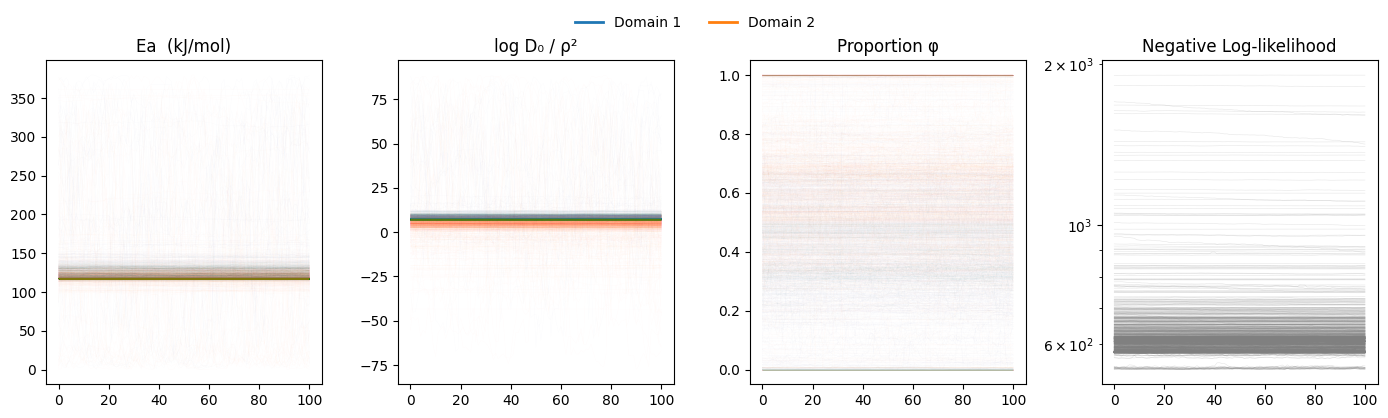

In [12]:
fs_np = jax.device_get(full_samples)          # dict of np.ndarray
T, C, num_domains = fs_np["logD0_r2"].shape     # time, chains, domains
fs_np["phi"] = jax.vmap(jax.vmap(stick_breaking))(fs_np["phi_raw"]) # vmap over time and chains

# --- reorder domains so that chain[0] is LRD, chain[1] is HRD, … ---------

# 1.  Compute the final (post-warm-up) diffusion constant for every chain & domain
#     logD0_r2 is already ln(D0 / r^2).
final_logD = fs_np["logD0_r2"][-1]          # shape (chains, domains)

# 2.  Build a permutation array that sorts domains *descending* by logD0_r2
#     (largest diffusion constant = lowest retention = LRD comes first)
perm = np.argsort(-final_logD, axis=1)      # shape (chains, domains)

# 3.  Apply the permutation to every recorded variable except the raw stick-breaking noise
for key in fs_np:
    if key == "phi_raw":
        continue
    fs_np[key] = np.take_along_axis(fs_np[key], perm[None, :, :], axis=2)

def logprob_from_arrays(Ea, logD0_r2, phi_raw):
    return log_prob({"Ea": Ea,
                     "logD0_r2": logD0_r2,
                     "phi_raw":  phi_raw})

# vmap over chains, then over time:  (T, C) array
ll = jax.vmap(
        jax.vmap(logprob_from_arrays,
                 in_axes=(0,0,0)),      # iterate over chains
                #  in_axes=(0,0)),      # iterate over chains
        in_axes=(0,0,0)                 # iterate over time
        # in_axes=(0,0)                 # iterate over time
     )(full_samples["Ea"], full_samples["logD0_r2"], full_samples["phi_raw"])
    #  )(full_samples["logD0_r2"], full_samples["phi_raw"])

ll = jax.device_get(ll)                 # move to NumPy for plotting

# ------------------------------------------------------------------
# 2) Plot traces (Ea, logD0_r2, phi) with faint strokes
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharex=True)
plot_items = [("Ea",        "Ea  (kJ/mol)"),
              ("logD0_r2",  "log D₀ / ρ²"),
              ("phi",       "Proportion φ")]

cmap   = get_cmap("tab10")     # high-contrast palette
alpha  = 10 / num_chains                   # faint lines
lw     = 0.4

for ax, (key, title) in zip(axes, plot_items):
    for d in range(num_domains):
        colour = cmap(d)
        traces = fs_np[key][:, :, d]          # (time, chain)
        for c in range(C):
            ax.plot(traces[:, c], color=colour, lw=lw, alpha=alpha)
    ax.set_title(title)

# 4th subplot: log-likelihood
axes[3].plot(-ll, color="gray", alpha=0.2, lw=lw)
axes[3].set_yscale('log')
axes[3].set_title("Negative Log-likelihood")

# domain-colour legend
handles = [Line2D([0], [0],
                  color=cmap(d), lw=2)
           for d in range(num_domains)]
labels  = [f"Domain {d+1}" for d in range(num_domains)]

fig.legend(handles=handles,
           labels=labels,          # <-- add this line
           loc="upper center",
           ncol=num_domains,
           frameon=False,
           bbox_to_anchor=(0.5, 1.05))

fig.tight_layout()
plt.show()
# 

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.stats import gaussian_kde


def animate_posterior_densities(
        fs_np, ll, *,
        duration=10, fps=12,
        filename="posterior_evolution.gif",
        n_grid=200):
    """
    Animated GIF of weighted posterior densities for Ea, logD0_r2, φ.

    duration : seconds of video  →  n_frames_target = fps * duration
    fps      : frames per second
    """

    # ------------------- set-up ------------------------------------------
    params  = [('Ea', r'$E_a$ (kJ mol$^{-1}$)'),
               ('logD0_r2', r'$\log(D_0/\rho^2)$'),
               ('phi', r'$\varphi$')]
    colors = [plt.cm.tab10(i) for i in range(num_domains)]
    T, C    = ll.shape

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for ax in axes:
        ax.set_ylabel("Posterior density")       # labels before tight_layout
        ax.grid(True, alpha=0.3)

    # reserve room: left=6 %, bottom=12 %, right=98 %, top=92 %
    fig.tight_layout(rect=[0.06, 0.12, 0.98, 0.92])

    # create a single title artist; we'll just rewrite its text
    title = fig.suptitle("", fontsize=14)

    lines, fills = [], [None] * (3 * num_domains)          # six objects (3 params × k domains)
    for ax in axes:
        for _ in range(num_domains):
            (l,) = ax.plot([], [], lw=2)
            lines.append(l)
        ax.set_ylabel("Posterior density")
        ax.grid(True, alpha=0.3)

    # x-axis ranges (constant)
    x_ranges = []
    for key, _ in params:
        vals = fs_np[key].ravel()                    # all time/chain/domain
        xr   = np.linspace(vals.min() - 0.1*np.ptp(vals),
                           vals.max() + 0.1*np.ptp(vals),
                           n_grid)
        x_ranges.append(xr)
    for ax, (_, lab) in zip(axes, params):
        ax.set_xlabel(lab)

    # frame selection (thinning if needed)
    n_frames_target = int(fps * duration)
    if T > n_frames_target:
        spacing   = math.floor(T / n_frames_target)
        frames_it = range(0, T, spacing)
    else:
        frames_it = range(T)

    # ------------------- pre-compute y-limits ---------------------------
    y_max = [0.0, 0.0, 0.0]                            # per-parameter
    for t in frames_it:
        w = np.exp(ll[t] - ll[t].max());  w /= w.sum()
        for p_idx, (key, _) in enumerate(params):
            vals_now = fs_np[key][t]                  # (chains, 2)
            for d in range(2):
                dens = gaussian_kde(vals_now[:, d], weights=w)(x_ranges[p_idx])
                y_max[p_idx] = max(y_max[p_idx], dens.max())

    for ax, ymax in zip(axes, y_max):
        ax.set_ylim(0, 1.05 * ymax)                   # fixed y-scale

    # ------------------- animation update ------------------------------
    def update(t_idx):
        w = np.exp(ll[t_idx] - ll[t_idx].max())
        w /= w.sum()

        obj = 0
        for (key, _), xr, ax in zip(params, x_ranges, axes):
            vals_now = fs_np[key][t_idx]              # (chains, domains)
            for d in range(num_domains):
                dens = gaussian_kde(vals_now[:, d], weights=w)(xr)

                lines[obj].set_data(xr, dens)
                lines[obj].set_color(colors[d])

                if fills[obj] is not None:
                    fills[obj].remove()
                fills[obj] = ax.fill_between(xr, dens, alpha=0.3,
                                             color=colors[d])
                obj += 1

        title.set_text(f"Posterior density – iteration {t_idx + 1}/{T}")

        return lines + fills

    # ------------------- build & save -----------------------------------
    anim = FuncAnimation(fig, update, frames=frames_it, blit=False)
    anim.save(filename, writer=PillowWriter(fps=fps))
    plt.close(fig)
    print(f"GIF saved to '{filename}'")

animate_posterior_densities(fs_np, ll, duration=5, fps=12, filename=f"results/posterior_evolution_{run_name}.gif")

GIF saved to 'results/posterior_evolution_2domains_1000chains_100steps.gif'


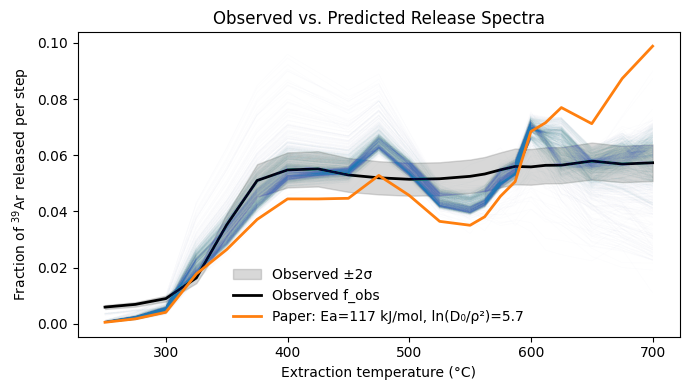

In [14]:
from turtle import st
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Assumed to exist in the workspace
#   • fractional_release(y)   – Fechtig-Kalbitzer function
#   • temps_K                 – (m,)  extraction temperatures [K]
#   • dt                      – (m,)  duration of each step [s]
#   • f_obs, sigma_obs        – (m,)  incremental release + 1 σ
#   • full_samples            – dict with keys 'Ea','logD0_r2','phi_raw'
# ------------------------------------------------------------------

R = 8.314  # J mol⁻¹ K⁻¹

# ------------------------------------------------------------------
# 1) Last posterior draw from every chain  →  predicted spectra
# ------------------------------------------------------------------
last = {k: v[-1] for k, v in full_samples.items()}       # (chains,k)
phi  = jax.vmap(stick_breaking)(last["phi_raw"])

EaJ  = last["Ea"] * 1e3                                  # (C,k)
# EaJ = 117.0 * 1e3
Dr2  = jnp.exp(last["logD0_r2"])                         # (C,k)

y_inc = Dr2[..., None] * jnp.exp(-EaJ[..., None] / (R * temps_K)) * dt  # (C,k,m)
# y_inc = Dr2[..., None] * jnp.exp(-EaJ / (R * temps_K)) * dt  # (C,k,m)
y_cum = jnp.cumsum(y_inc, axis=-1)                       # (C,k,m)
F_cum = fractional_release(y_cum)                        # (C,k,m)

dF   = jnp.diff(F_cum, axis=-1, prepend=jnp.zeros_like(F_cum[..., :1])) # (C,k,m)
Ffin = (phi * F_cum[..., -1]).sum(axis=1)[:, None]        # (C,1)
f_pred = (phi[..., None] * dF).sum(axis=1) / Ffin         # (C,m)

f_pred_np = jax.device_get(f_pred)                        # move to host

# ------------------------------------------------------------------
# 2) “Paper” single-domain reference: Ea=117 kJ mol⁻¹, ln(D0/ρ²)=5.7
# ------------------------------------------------------------------
Ea_ref          = 117.0                    # kJ mol⁻¹
logDr2_ref_ln   = 5.7
Dr2_ref         = jnp.exp(logDr2_ref_ln)

y_inc_ref  = Dr2_ref * jnp.exp(-Ea_ref*1e3 / (R * temps_K)) * dt
y_cum_ref  = jnp.cumsum(y_inc_ref)
F_cum_ref  = fractional_release(y_cum_ref[None, :])[0]
dF_ref     = jnp.diff(F_cum_ref, prepend=0.0)
f_pred_ref = dF_ref / F_cum_ref[-1]

f_pred_ref_np = jax.device_get(f_pred_ref)

# ------------------------------------------------------------------
# 3) Plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))

final_cumulative_release_with_extraction_time = filtered_df["F"].values[-1]
scaled_f_obs = f_obs / final_cumulative_release_with_extraction_time

# observed + 2σ band
ax.fill_between(temps_K - 273.15,
                scaled_f_obs - 2*sigma_obs,
                scaled_f_obs + 2*sigma_obs,
                color='grey', alpha=0.3, label='Observed ±2σ')
ax.plot(temps_K - 273.15, scaled_f_obs, color='k', lw=2, label='Observed f_obs')

# posterior trajectories (blue, faint)
for fp in f_pred_np:
    ax.plot(temps_K - 273.15, fp, color='tab:blue', alpha=10 / len(f_pred_np), lw=0.6)

# reference curve (orange)
ax.plot(temps_K - 273.15, f_pred_ref_np,
        color='tab:orange', lw=2,
        label='Paper: Ea=117 kJ/mol, ln(D₀/ρ²)=5.7')

ax.set_xlabel('Extraction temperature (°C)')
ax.set_ylabel('Fraction of $^{39}$Ar released per step')
ax.set_title('Observed vs. Predicted Release Spectra')
ax.legend(frameon=False)
plt.tight_layout()
plt.show()


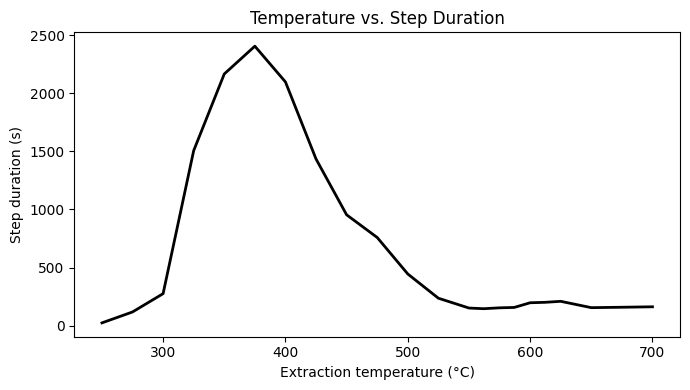

In [15]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(temps_K - 273.15, dt, 'k-', lw=2)
ax.set_xlabel('Extraction temperature (°C)')
ax.set_ylabel('Step duration (s)')
ax.set_title('Temperature vs. Step Duration')
plt.tight_layout()
plt.show()


In [16]:
import pickle
pickle.dump(fs_np, open(f"results/samples_{run_name}.pkl", "wb"))